In [20]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
import datetime
from sklearn.metrics import mean_squared_error

# What did the data look like originally?

In [21]:
# Load the original data set - BEFORE transformations
original_data = pd.read_csv('original_data.csv')
original_data['Date'] = pd.to_datetime(original_data['Date'], infer_datetime_format=True)

# Display
original_data.head()

,Unnamed: 0,Date,Start_Station_Capacity,Station_Number,Status,Bike_Count,Count_Percent_Capacity
0,24,2015-07-01 08:25:00,19.0,31116,add bike,1.0,5.263158
1,26,2015-07-01 08:26:00,19.0,31116,subtract bike,0.0,0.000000
2,28,2015-07-01 09:42:00,19.0,31116,add bike,1.0,5.263158
3,30,2015-07-01 09:55:00,19.0,31116,subtract bike,0.0,0.000000
4,32,2015-07-01 10:38:00,19.0,31116,add bike,1.0,5.263158


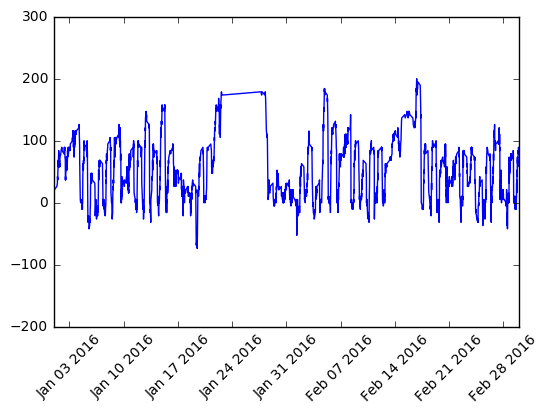

In [22]:
# For a random, specific station, 31116, what did the time series look like?
original_data_31116 = original_data[original_data['Station_Number'] == 31116]

plt.plot(original_data_31116['Date'], original_data_31116['Count_Percent_Capacity'])
plt.ylim(-200, 300)
plt.xlim('2016-01-01 00:00:00', '2016-03-01 00:00:00') # Random months to show snapshot
plt.xticks(rotation=45);

In [23]:
# Explore descriptive stats for percent capacity
original_data_31116['Count_Percent_Capacity'].describe()

count    50836.000000
mean        57.821850
std         52.297961
min        -94.736842
25%         15.789474
50%         47.368421
75%         94.736842
max        268.421053
Name: Count_Percent_Capacity, dtype: float64

# What does the data look like after transformations?

In [24]:
# Load the new, transformed data set
transformed_data = pd.read_csv('transformed_data.csv')
transformed_data['Date'] = pd.to_datetime(transformed_data['Date'], infer_datetime_format=True)

# Display
transformed_data.head()

,Unnamed: 0,Date,Station_Number,Count_Percent_Capacity
0,0,2015-07-01 08:25:00,31116,5.263158
1,1,2015-07-01 08:26:00,31116,0.000000
2,2,2015-07-01 09:42:00,31116,5.263158
3,3,2015-07-01 09:55:00,31116,0.000000
4,4,2015-07-01 10:38:00,31116,5.263158


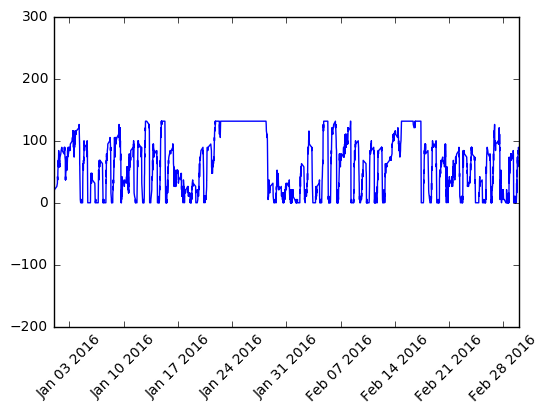

In [25]:
# For a random, specific station, 31116, what did the time series look like?
transformed_data_31116 = transformed_data[transformed_data['Station_Number'] == 31116]

plt.plot(transformed_data_31116['Date'], transformed_data_31116['Count_Percent_Capacity'])
plt.ylim(-200, 300)
plt.xlim('2016-01-01 00:00:00', '2016-03-01 00:00:00') # Random months to show snapshot
plt.xticks(rotation=45);

In [26]:
# Did tranforming change percent capacity?
transformed_data_31116['Count_Percent_Capacity'].describe()

count    50836.000000
mean        55.921208
std         44.691566
min          0.000000
25%         15.789474
50%         47.368421
75%         94.736842
max        131.578947
Name: Count_Percent_Capacity, dtype: float64

# Upsample the transformed data to every hour

In [27]:
# Use linear interpolation to find data at every hour since the start of the data for station 31116
new_series_31116 = pd.DataFrame()
add_hour = datetime.timedelta(hours=1)

temp_df = transformed_data_31116[transformed_data_31116['Station_Number'] == 31116]

start = temp_df['Date'].iloc[0] + datetime.timedelta(seconds=1)
end = temp_df['Date'].iloc[-1]
new_datetimes = []

while start <= (end + add_hour):
    new_datetimes.append(start)
    start += add_hour

new_datetimes_df = pd.DataFrame({'Date':new_datetimes, 
                                 'Station_Number':'new_datetime'})

updated_temp_df = temp_df.append(new_datetimes_df)
updated_temp_df.sort_values(by='Date', inplace=True)
#updated_temp_df.fillna(method='ffill', inplace=True)
updated_temp_df['Count_Percent_Capacity'] = updated_temp_df['Count_Percent_Capacity'].interpolate(method='linear')
updated_temp_df = updated_temp_df[updated_temp_df['Station_Number'] != 31116]
updated_temp_df['Station_Number'] = 31116

new_series_31116 = new_series_31116.append(updated_temp_df)

In [28]:
# Display
new_series_31116.head()

,Count_Percent_Capacity,Date,Station_Number,Unnamed: 0
0,2.631579,2015-07-01 08:25:01,31116,NaN
1,2.631579,2015-07-01 09:25:01,31116,NaN
2,2.631579,2015-07-01 10:25:01,31116,NaN
3,1.315789,2015-07-01 11:25:01,31116,NaN
4,2.631579,2015-07-01 12:25:01,31116,NaN


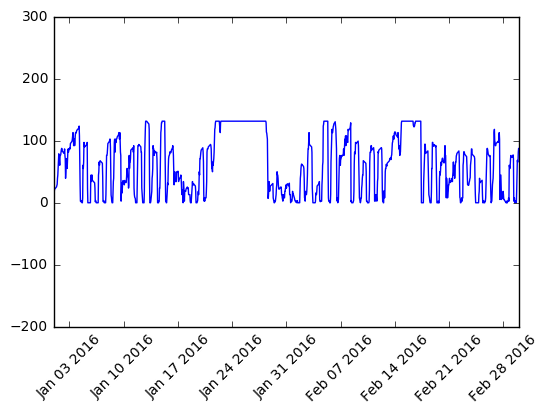

In [29]:
# Does it look like the upsampling changed the representation of the data?
plt.plot(new_series_31116['Date'], new_series_31116['Count_Percent_Capacity'])
plt.ylim(-200, 300)
plt.xlim('2016-01-01 00:00:00', '2016-03-01 00:00:00') # Random months to show snapshot
plt.xticks(rotation=45);

In [30]:
# Did upsampling change percent capacity?
new_series_31116['Count_Percent_Capacity'].describe()

count    10985.000000
mean        62.335961
std         48.511890
min          0.000000
25%         13.157895
50%         60.526316
75%        107.894737
max        131.578947
Name: Count_Percent_Capacity, dtype: float64

# Try an ARIMA model on the upsampled data for station 31116

In [31]:
# Take the subset of transformed data for station 31116 as a series object
#series_31116 = transformed_data_31116[['Date', 'Count_Percent_Capacity']]
series_31116 = new_series_31116.copy()
series_31116.set_index('Date', inplace=True)
series_31116 = series_31116['Count_Percent_Capacity']

# Display
series_31116 .head()

Date
2015-07-01 08:25:01    2.631579
2015-07-01 09:25:01    2.631579
2015-07-01 10:25:01    2.631579
2015-07-01 11:25:01    1.315789
2015-07-01 12:25:01    2.631579
Name: Count_Percent_Capacity, dtype: float64

In [32]:
# Create function for stationarity test
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.DataFrame.rolling(timeseries, window=12,center=False).mean()
    rolstd = pd.DataFrame.rolling(timeseries, window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

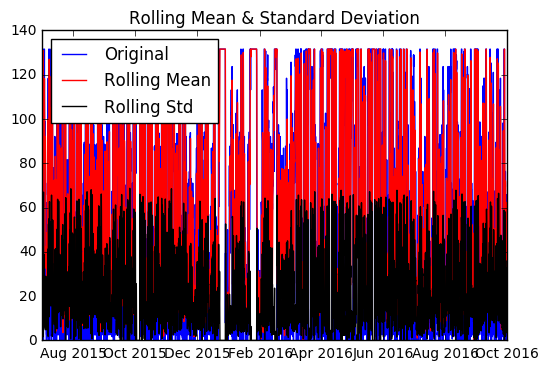

Results of Dickey-Fuller Test:
Test Statistic                -1.219115e+01
p-value                        1.284862e-22
#Lags Used                     3.800000e+01
Number of Observations Used    1.094600e+04
Critical Value (1%)           -3.430948e+00
Critical Value (10%)          -2.566911e+00
Critical Value (5%)           -2.861804e+00
dtype: float64


In [33]:
# Run a test for stationarity on series_31116
test_stationarity(series_31116)

In [34]:
# Create ACF and PACF plots as inputs to the ARIMA model
lag_pacf = pacf(series_31116, nlags=20, method='ols')

(-0.05, 0.05)

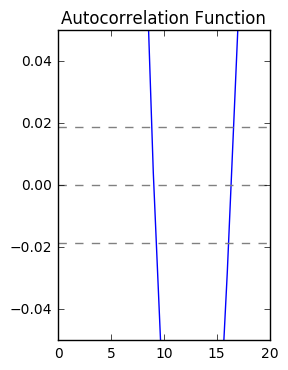

In [35]:
# Plot ACF: 
lag_acf = acf(series_31116, nlags=20)
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series_31116)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(series_31116)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.ylim(-.05, .05)

(-0.05, 0.05)

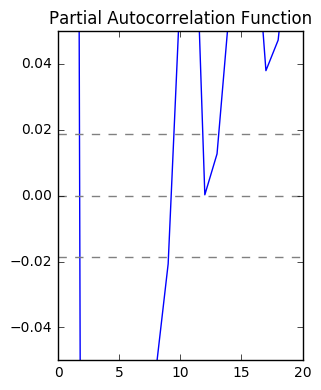

In [36]:
# Plot PACF:
lag_pacf = pacf(series_31116, nlags=20, method='ols')
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series_31116)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(series_31116)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.ylim(-.05, .05)

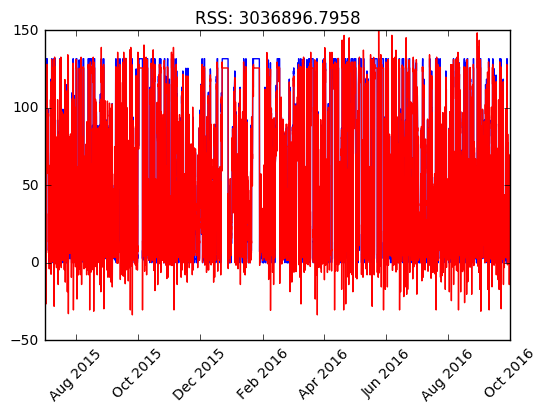

In [37]:
# AR Model
model = ARIMA(series_31116, order=(2, 0, 0))
results_AR = model.fit(disp=-1)  
plt.plot(series_31116)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-series_31116)**2))
plt.xticks(rotation=45);

In [38]:
# MA Model  
model = ARIMA(series_31116, order=(0, 0, 9))   
results_MA = model.fit(disp=-1)  
plt.plot(series_31116)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-series_31116)**2))
plt.xticks(rotation=45);

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

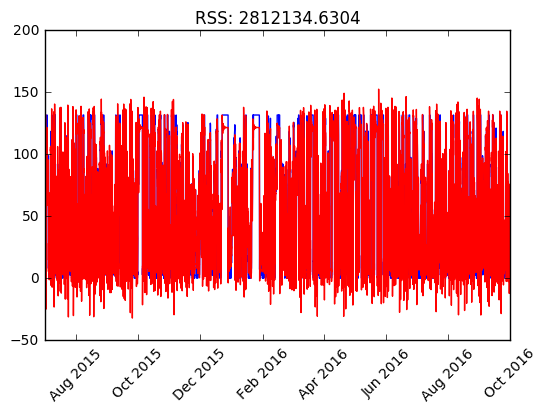

In [39]:
# Combined ARIMA Model
model = ARIMA(series_31116, order=(2, 0, 9))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(series_31116)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-series_31116)**2))
plt.xticks(rotation=45);

In [40]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARMA Model Results                                
==================================================================================
Dep. Variable:     Count_Percent_Capacity   No. Observations:                10985
Model:                         ARMA(2, 9)   Log Likelihood              -46038.973
Method:                           css-mle   S.D. of innovations             15.990
Date:                    Wed, 05 Apr 2017   AIC                          92103.945
Time:                            18:02:09   BIC                          92198.901
Sample:                        07-01-2015   HQIC                         92135.937
                             - 10-01-2016                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           62.3294      1.047     59.512      0.000      60.277      64.382
ar.L1.Count_Percent_Capacity     1.8793      0.005    352.755      0.000       1.869       1.890
ar.L2.Count_Percent_Capacity    -0.9493      0.005   -189.342      0.000      -0.959      -0.939
ma.L1.Count_Percent_Capacity    -0.7714      0.011    -69.471      0.000      -0.793      -0.750
ma.L2.Count_Percent_Capacity    -0.0769      0.012     -6.298      0.000      -0.101      -0.053
ma.L3.Count_Percent_Capacity     0.0203      0.012      1.649      0.099      -0.004       0.044
ma.L4.Count_Percent_Capacity     0.0544      0.013      4.259      0.000       0.029       0.079
ma.L5.Count_Percent_Capacity     0.0633      0.013      5.027      0.000       0.039       0.088
ma.L6.Count_Percent_Capacity     0.0599      0.013      4.570      0.000       0.034       0.086
ma.L7.Count_Percent_Capacity     0.0529      0.014      3.732      0.000       0.025       0.081
ma.L8.Count_Percent_Capacity     0.0485      0.012      3.969      0.000       0.025       0.072
ma.L9.Count_Percent_Capacity     0.0300      0.011      2.806      0.005       0.009       0.051
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9898           -0.2714j            1.0264           -0.0426
AR.2            0.9898           +0.2714j            1.0264            0.0426
MA.1            0.9868           -0.3449j            1.0453           -0.0535
MA.2            0.9868           +0.3449j            1.0453            0.0535
MA.3            0.7486           -1.2853j            1.4874           -0.1661
MA.4            0.7486           +1.2853j            1.4874            0.1661
MA.5           -0.3147           -1.5898j            1.6206           -0.2811
MA.6           -0.3147           +1.5898j            1.6206            0.2811
MA.7           -1.7662           -0.0000j            1.7662           -0.5000
MA.8           -1.3445           -1.0778j            1.7232           -0.3925
MA.9           -1.3445           +1.0778j            1.7232            0.3925
-----------------------------------------------------------------------------
"""

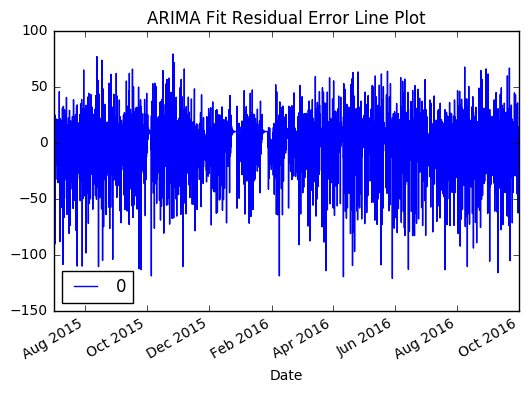

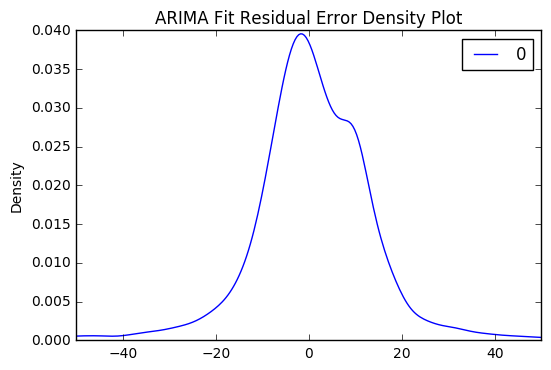

Describe residuals:
                  0
count  10985.000000
mean      -0.003083
std       16.000656
min     -121.052457
25%       -5.881615
50%        0.298306
75%        8.587163
max       79.397846


In [41]:
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot()
plt.title('ARIMA Fit Residual Error Line Plot')
plt.show()

residuals.plot(kind='kde')
plt.xlim(-50,50)
plt.title('ARIMA Fit Residual Error Density Plot')
plt.show()

print('Describe residuals:')
print(residuals.describe())

### *Remember to add in mentions to Analytics Vidhya  and Machine Learning Mastery for using their code and articles*

# AR MODEL - ORDER (2, 0, 0)

In [48]:
# Rolling Forecast
X = series_31116
size = int(len(X) * 0.99)
train, test = X[0:size], X[size:len(X)]
history_AR = [x for x in train]
predictions_AR = list()
for t in range(len(test)):
    model_AR = ARIMA(history_AR, order=(2,0,0))
    model_fit_AR = model_AR.fit(disp=0)
    output_AR = model_fit_AR.forecast()
    yhat_AR = output_AR[0]
    predictions_AR.append(yhat_AR)
    obs_AR = test[t]
    history_AR.append(obs_AR)
    print('predicted=%f, expected=%f' % (yhat_AR, obs_AR))

predicted=13.885826, expected=2.631579
predicted=6.221082, expected=2.631579
predicted=7.776207, expected=5.263158
predicted=10.958449, expected=5.263158
predicted=10.179220, expected=2.631579
predicted=6.994797, expected=2.631579
predicted=7.771666, expected=55.263158
predicted=71.435880, expected=81.578947
predicted=87.706474, expected=97.368421
predicted=99.022181, expected=97.368421
predicted=94.349919, expected=97.368421
predicted=94.350180, expected=92.105263
predicted=87.983507, expected=97.368421
predicted=95.908405, expected=98.245614
predicted=95.412560, expected=96.491228
predicted=93.031036, expected=93.684211
predicted=90.154881, expected=92.631579
predicted=89.712393, expected=91.578947
predicted=88.750870, expected=90.526316
predicted=87.789221, expected=92.105263
predicted=90.011096, expected=60.526316
predicted=51.342530, expected=18.421053
predicted=9.739780, expected=2.631579
predicted=3.104403, expected=0.000000
predicted=4.597057, expected=0.000000
predicted=5.3755

Test MSE: 217.016
Test RMSE: 14.731


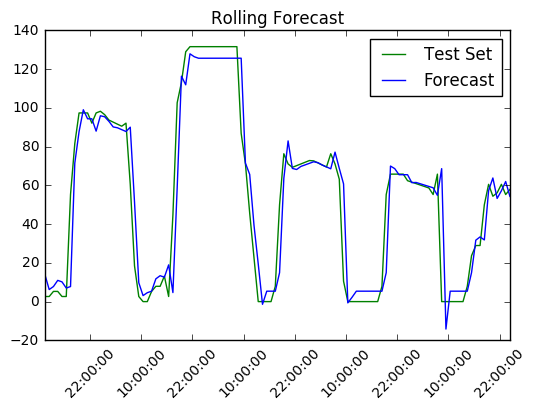

In [87]:
# Make temp df to handle dates and prediction values
pred_temp_df = pd.DataFrame(test)
pred_temp_df['predictions'] = predictions_AR
pred_temp_df['predictions'] = pred_temp_df['predictions'].astype(float)

# Display error rates
error = mean_squared_error(test, predictions_AR)
print('Test MSE: %.3f' % error)
print('Test RMSE: %.3f' % error**0.5)

# Plot forecasts
plt.plot(thing.Count_Percent_Capacity, color='green', label='Test Set')
plt.plot(thing.predictions, color='blue', label='Forecast')
plt.legend(loc='upper right')
plt.title('Rolling Forecast')
plt.xticks(rotation=45);

In [46]:
results_AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARMA Model Results                                
==================================================================================
Dep. Variable:     Count_Percent_Capacity   No. Observations:                10985
Model:                         ARMA(2, 0)   Log Likelihood              -46461.638
Method:                           css-mle   S.D. of innovations             16.618
Date:                    Wed, 05 Apr 2017   AIC                          92931.276
Time:                            18:04:07   BIC                          92960.494
Sample:                        07-01-2015   HQIC                         92941.120
                             - 10-01-2016                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           62.2942      1.835     33.944      0.000      58.697      65.891
ar.L1.Count_Percent_Capacity     1.2105      0.009    132.870      0.000       1.193       1.228
ar.L2.Count_Percent_Capacity    -0.2968      0.009    -32.578      0.000      -0.315      -0.279
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1509           +0.0000j            1.1509            0.0000
AR.2            2.9273           +0.0000j            2.9273            0.0000
-----------------------------------------------------------------------------
"""

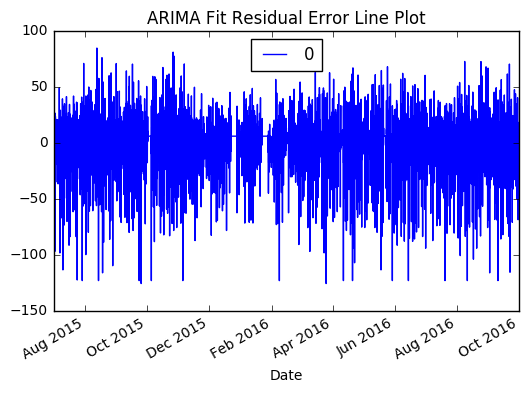

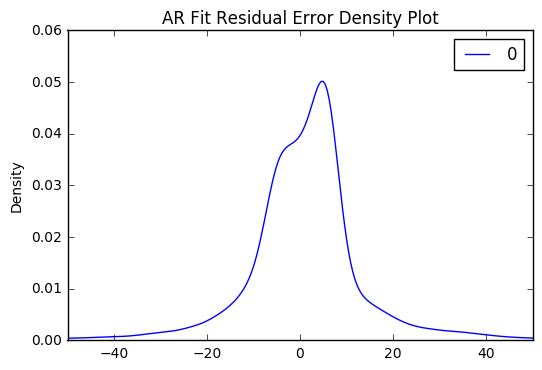

Describe residuals:
                  0
count  10985.000000
mean       0.001928
std       16.627798
min     -125.596797
25%       -5.151356
50%        1.634525
75%        5.982150
max       84.654551


In [47]:
# plot AR residual errors
residuals = pd.DataFrame(results_AR.resid)
residuals.plot()
plt.title('ARIMA Fit Residual Error Line Plot')
plt.show()

residuals.plot(kind='kde')
plt.xlim(-50,50)
plt.title('AR Fit Residual Error Density Plot')
plt.show()

print('Describe residuals:')
print(residuals.describe())